C:\Users\jarfi\AppData\Local\Temp\ipykernel_5332\1259805677.py:67: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rssi = [x for x in Xcols_all if rssi*'rssi' in x.split('_') ]
C:\Users\jarfi\AppData\Local\Temp\ipykernel_5332\1259805677.py:68: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  X_rc = [x for x in Xcols_all if rc*'rc' in x.split('_') ]


0.9963129864809505

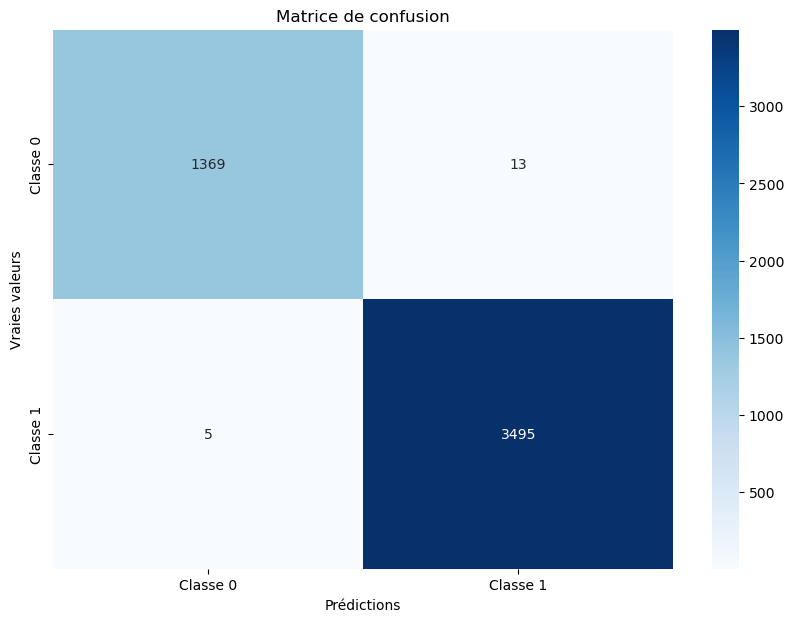

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import seaborn as sns
from config import dataframe

def dataset (df_timing_slices, reflist, timing, rssi_quantile ):
    # regroupe le dataset par les colonnes suivantes 'Epc', 'window_run_id', 'slice_id', 'loc' puis calule le quantile mediant c'est à dire divise le dataset en deux parties égales
    ds_rssi = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc'])['Rssi'].quantile(rssi_quantile)\
        .unstack(['slice_id', 'loc'], fill_value=-110)
    ds_rssi.columns = [x[0]+'_'+x[1] for x in ds_rssi.columns]
    ds_rssi = ds_rssi.reset_index(drop = False)
    ds_rc = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']).size()\
        .unstack(['slice_id', 'loc'], fill_value=0)
    ds_rc.columns = [x[0]+'_'+x[1] for x in ds_rc.columns]
    ds_rc = ds_rc.reset_index(drop = False)
    ds = pd.merge(ds_rssi, ds_rc, on=['Epc', 'window_run_id'], suffixes=['_rssi', '_rc'])
    #window_width
    ds = pd.merge(ds, timing[['window_run_id', 'window_width']], on ='window_run_id', how='left')
    #Epcs_window
    Q_Epcs_window = df_timing_slices.groupby(['window_run_id'])['Epc'].nunique().rename('Epcs_window').reset_index(drop=False)
    ds= pd.merge(ds, Q_Epcs_window, on='window_run_id', how='left')
    #reads_window
    Q_reads_window = df_timing_slices.groupby(['window_run_id']).size().rename('reads_window').reset_index(drop=False)
    ds= pd.merge(ds, Q_reads_window, on= 'window_run_id', how='left')
    ds = pd.merge(ds, reflist, on='Epc', how='left')
    ds['actual']= ds['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ds['refListId_actual']
    ds['actual'] = ds.apply(lambda row: 'in' if int(row['window_run_id'].split('_')[0]) == row['refListId_actual'] else 'out', axis=1)
    vrai=ds[ds['actual']== 'in']
    faux=ds[ds['actual']== 'out']
    true= vrai.shape[0]
    #print('true',true)
    false= faux.shape[0]
    return ds

def Xcols_func(features, Xcols_all):
    #Features
    Features=pd.DataFrame(
    [
        ['all', True, True, False, True, True, True ],
        ['rssi & rc only', True, True, False, False, False, False],
        ['rssi & rc_mid', True, True, True, False, False, False ],
        ['rssi only', True, False, True, False, False, False ],
        ['rc only', False, True, False, False, False, False ],
    ],
        columns=['features', 'rssi', 'rc', 'rc_mid_only', 'Epcs_window', 'reads_window', 'window_width']
    )
    Features_temp = Features [Features['features']==features]
    X=[]
    rssi = Features_temp ['rssi'].values[0]
    rc = Features_temp['rc'].values[0]
    rc_mid_only = Features_temp['rc_mid_only'].values[0]
    Epcs_window = Features_temp['Epcs_window'].values[0]
    reads_window = Features_temp['reads_window'].values[0]
    window_width = Features_temp['window_width'].values[0]
    X_rssi = [x for x in Xcols_all if rssi*'rssi' in x.split('_') ]
    X_rc = [x for x in Xcols_all if rc*'rc' in x.split('_') ]
    X = X_rssi + X_rc
    if Epcs_window:
         X.append('Epcs_window')
    if Epcs_window:
        X.append('reads_window')
    if Epcs_window:
        X.append('window_width')
    return X

def filter_columns(df, column_names):
    filtered_df = pd.DataFrame()  # Créer un nouveau DataFrame pour stocker les résultats filtrés
    for column in column_names:
        if column in df.columns:
            # Si le nom de la colonne est présent dans le DataFrame d'origine
            # Ajouter la colonne correspondante dans le DataFrame filtré
            filtered_df[column] = df[column]
    return filtered_df

def knn_model (n_neighbors_knn,weights_knn,algorithm,p_knn):
    def keys_exist(d, keys):
        return all(key in d for key in keys)

    # Liste des clés à vérifier
    required_keys = ['df_timing_slices', 'timing_slices', 'reflist', 'timing']

    if dataframe is not None and keys_exist(dataframe, required_keys):
        df_timing_slices = dataframe['df_timing_slices']
        timing_slices = dataframe['timing_slices']
        reflist = dataframe['reflist']
        timing = dataframe['timing'] 
    else:
        df_timing_slices = pd.read_excel("df_timing_slices.xlsx")
        timing_slices = pd.read_excel("timing_slices.xlsx")
        reflist = pd.read_excel("reflist.xlsx")
        timing = pd.read_excel("timing.xlsx")
    timing['window_width'] = (timing['Stopdown'] - timing['Startup']).apply(lambda x:x.total_seconds())
    timing['window_run_id'] = timing['refListId'].astype(str) +"_"+ timing['run'].astype(str)
    a =  dataset (df_timing_slices, reflist, timing, 1)
    b=Xcols_func('all', a.columns)  
    X=filter_columns(a, b)
    # Créer un classificateur k-NN
    clf = KNeighborsClassifier(n_neighbors=n_neighbors_knn,weights=weights_knn,algorithm=algorithm,p=p_knn)
    pred_ml = pd.DataFrame()
    y = a['actual']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, stratify=y)
    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain_std = scaler.transform(Xtrain)
    Xtest_std = scaler.transform(Xtest)
    clf.fit(Xtrain_std, ytrain)
    ypred = clf.predict(Xtest_std)
    scores = cross_val_score(clf, Xtrain_std, ytrain, cv=5)
    accuracy = ( ytest == ypred ).mean()
    cm = confusion_matrix(ypred, ytest)    

    #print(accuracy,scores,scores.mean()) 
    ypred_series = pd.Series(ypred, index=ytest.index, name='pred_ml')
    temp = a.loc[ytest.index, ['Epc', 'window_run_id', 'actual']]

    temp = temp.join(ypred_series)
    pred_ml = pd.concat([pred_ml, temp], ignore_index=True)

    pred_ml.loc[:, 'pred_ml_bool'] = (pred_ml.loc[:, 'actual'] == pred_ml.loc[:, 'pred_ml'])
    pred_ml = pred_ml [['Epc', 'window_run_id', 'actual', 'pred_ml', 'pred_ml_bool']]

    '''
    print("Précision du model :", accuracy)
    print("\nPrécision par partie avec la validation croisée:", scores)
    print("\nMoyenne des précisions de la validation croisée:", scores.mean())
    print("\nMatrice de confusion : \n")
    print(cm)
    '''
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies valeurs')
    plt.title('Matrice de confusion')
    plt.savefig("knn_cm.png")
    return accuracy

    
knn_model(5,'uniform','auto',2)




# In[ ]:




